## Prepare Dataset and Specify Parameters (please only edit cells in this section)

In [1]:
# Parameters to specify

# Specify here at what frame NC14 starts
nc14_start_frame = 438

# Any trace with frame number smaller than min_frames will be filtered out
min_frames = 40

# Number of bins you want to split the full embryo into
num_bins = 42

In [2]:
# Dataset Directory

dataset_folder = '/mnt/Data1/Josh/transcription_pipeline-main/'

RBSPWM_datasets = [
    "test_data/2024-02-26/Halo-RBSPWM_embryo01",
    "test_data/2024-02-26/Halo-RBSPWM_embryo02",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo01",
    "test_data/2024-05-07/Halo552-RBSPWM_embryo02",
    "test_data/2024-05-09/Halo552-RBSPWM_embryo01",
]

RBSVar2_datasets = [
    "test_data/2024-07-23/Halo673_RBSVar2_embryo01",
    "test_data/2024-07-25/Halo673_RBSVar2_embryo01"
]

test_dataset_name = dataset_folder + RBSVar2_datasets[1]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Josh/transcription_pipeline-main/test_data/2024-07-25/Halo673_RBSVar2_embryo01


In [3]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

import os
import matplotlib.pyplot as plt

`JAVA_HOME` environment variable set to /mnt/Data1/Josh/miniforge3/envs/transcription_pipeline


In [4]:
# Specify how you would want the plots to be shown: Use TkAgg if you use PyCharm, or widget if you use a browser

# mpl.use('TkAgg')
%matplotlib widget

## Import Dataset

### Import MS2 Dataset

Detect whether the dataset has already been converted into `zarr` files, i.e. whether there's "previously" processed data. If so, load the previous results.

In [5]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [6]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

### Import FullEmbryo Dataset

In [7]:
FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
    name_folder=test_dataset_name,
    #import_previous=True
)
# Loading FullEmbryo dataset is not working currently, but reported to Yovan where it only reads in the last channel
# FullEmbryo_dataset.save()

## Starting a DASK Client for parallel processing

In [8]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="6GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39517 instead
  warnings.warn(
2025-01-30 17:00:38,579 - distributed.deploy.spec - WARNING - Cluster closed without starting up


Cluster already running
<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>


/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+-------------+----------+-----------+-----------+
| Package     | Client   | Scheduler | Workers   |
+-------------+----------+-----------+-----------+
| cloudpickle | 3.0.0    | 3.1.0     | 3.1.0     |
| dask        | 2023.5.1 | 2024.12.0 | 2024.12.0 |
| msgpack     | 1.0.8    | 1.1.0     | 1.1.0     |
| numpy       | 1.24.4   | 1.22.4    | 1.22.4    |
| pandas      | 2.0.2    | 2.2.3     | 2.2.3     |
| toolz       | 0.12.1   | 1.0.0     | 1.0.0     |
| tornado     | 6.4.1    | 6.4.2     | 6.4.2     |
+-------------+----------+-----------+-----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [9]:
client.restart()

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>

In [10]:
client

<Client: 'tcp://127.0.0.1:37763' processes=14 threads=14, memory=78.23 GiB>

## Nuclear Tracking

Detect whether the nuclear tracking has been done "previously." If so, load the previous results.

In [11]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [12]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[0],
        global_metadata=dataset.export_global_metadata[0],
        frame_metadata=dataset.export_frame_metadata[0],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


## Spot Tracking

Detect whether the spot tracking has been done "previously." If so, load the previous results.

In [13]:
spot_tracking_previous = os.path.isdir(test_dataset_name + '/spot_analysis_results')
spot_tracking_previous

True

In [14]:
%%time

if spot_tracking_previous:
    # Load spot tracking results
    print('Load from spot tracking results')
    
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do spot tracking and save the results
    print('Do spot tracking for the dataset')
    
    spot_tracking = spot_pipeline.Spot(
        data=dataset.channels_full_dataset[1],
        global_metadata=dataset.export_global_metadata[1],
        frame_metadata=dataset.export_frame_metadata[1],
        labels=None,#nuclear_tracking.reordered_labels,
        expand_distance=3,
        search_range_um=4.2,
        retrack_search_range_um=4.5,
        threshold_factor=1.3,
        memory=3,
        retrack_after_filter=False,
        stitch=True,
        min_track_length=0,
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        keep_bandpass=False,
        keep_futures=False,
        keep_spot_labels=False,
        evaluate=True,
        retrack_by_intensity=True,
        client=client,
    )
    
    spot_tracking.extract_spot_traces(
        working_memory_folder=test_dataset_name, 
        stitch=True,
        retrack_after_filter=True,
        trackpy_log_path = test_dataset_name+'/trackpy_log'
    )
    
    # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
    # quantification information.
    spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

Load from spot tracking results
CPU times: user 1.17 s, sys: 63.1 ms, total: 1.23 s
Wall time: 1.13 s


### Make Compiled Dataframe

In [15]:
# Load spot tracking dataframe
spot_df = spot_tracking.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y"
    ],
    nuclear_tracking_dataframe=None,
)

compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y
0,1,"[506, 507, 511, 512, 513, 514, 515, 517, 518, ...","[2300.7059993743896, 2304.7430000305176, 2322....","[72.1570804597701, 53.93129347826087, 95.00423...","[25.268212723555116, 24.193128325434877, 23.27...","[425.48808831836254, 423.8314928296911, 425.13...","[221.00383393743027, 221.58308686421765, 221.5..."
1,2,"[460, 461, 462, 463, 464, 465, 466, 467, 468, ...","[2091.4230003356934, 2095.882999420166, 2100.1...","[57.47963945578232, 38.66103448275862, 90.2138...","[27.24615631798166, 25.318037332850935, 24.569...","[122.58614821001362, 123.76488548423376, 126.0...","[17.180038487563998, 17.208933264743397, 18.12..."
2,3,"[527, 528, 529, 530, 531, 532, 533, 534, 535, ...","[2394.573999404907, 2399.2339992523193, 2403.4...","[67.31827607361961, 10.19521568627451, 67.1475...","[26.219966228377146, 26.957198706766793, 25.65...","[588.016012440591, 586.074051884851, 588.18053...","[48.20524698088067, 48.37057827336589, 48.2503..."
3,4,"[572, 573, 574, 576, 577, 578, 580, 581, 582, ...","[2601.6180000305176, 2605.8780002593994, 2610....","[131.19976923076925, 114.73455625, 112.1208231...","[23.632369088123415, 26.48124363284603, 24.361...","[247.29672998614768, 245.9633552657412, 245.16...","[119.09766185700249, 119.2585299587735, 118.06..."
4,5,"[486, 489, 490, 491, 492, 493, 494, 495, 496, ...","[2211.6900005340576, 2225.287000656128, 2229.7...","[49.39227659574468, 71.93047777777778, 75.6659...","[23.603968369418688, 23.202337971412053, 23.80...","[473.56080767748307, 471.83975365873124, 471.4...","[127.7748944142374, 128.7753637411546, 128.167..."


## Full Embryo Analysis

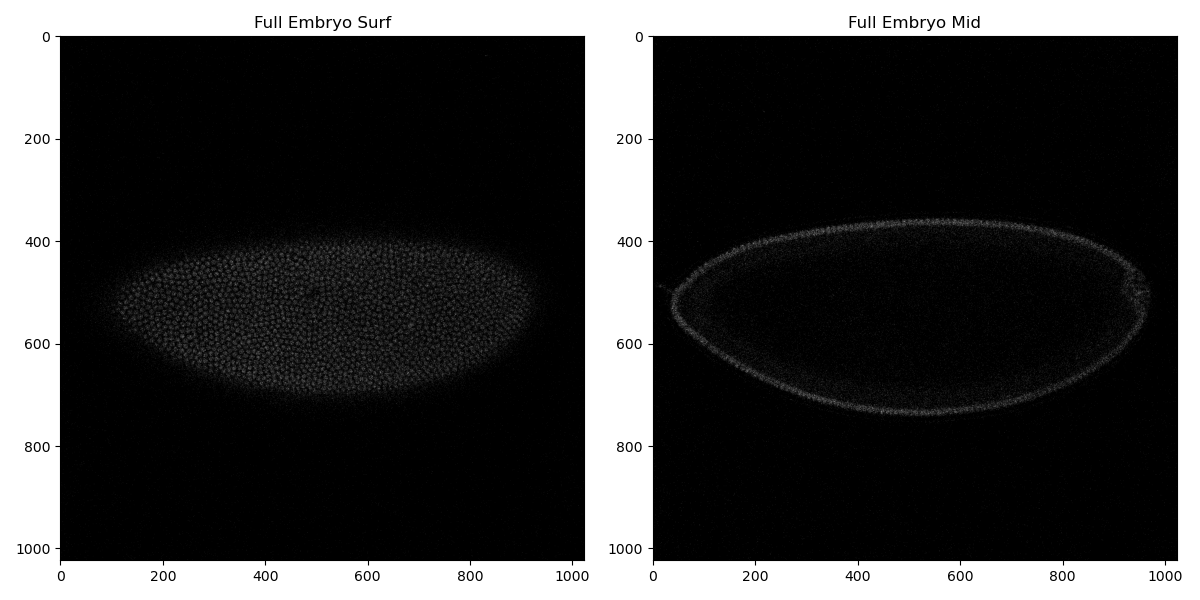

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_surf[0][0, :, :], cmap='gray')
plt.title('Full Embryo Surf')

plt.subplot(1, 2, 2)
plt.imshow(FullEmbryo_dataset.channels_full_dataset_mid[0][0, :, :], cmap='gray')
plt.title('Full Embryo Mid')

plt.tight_layout()
plt.show()

In [17]:
fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=0)

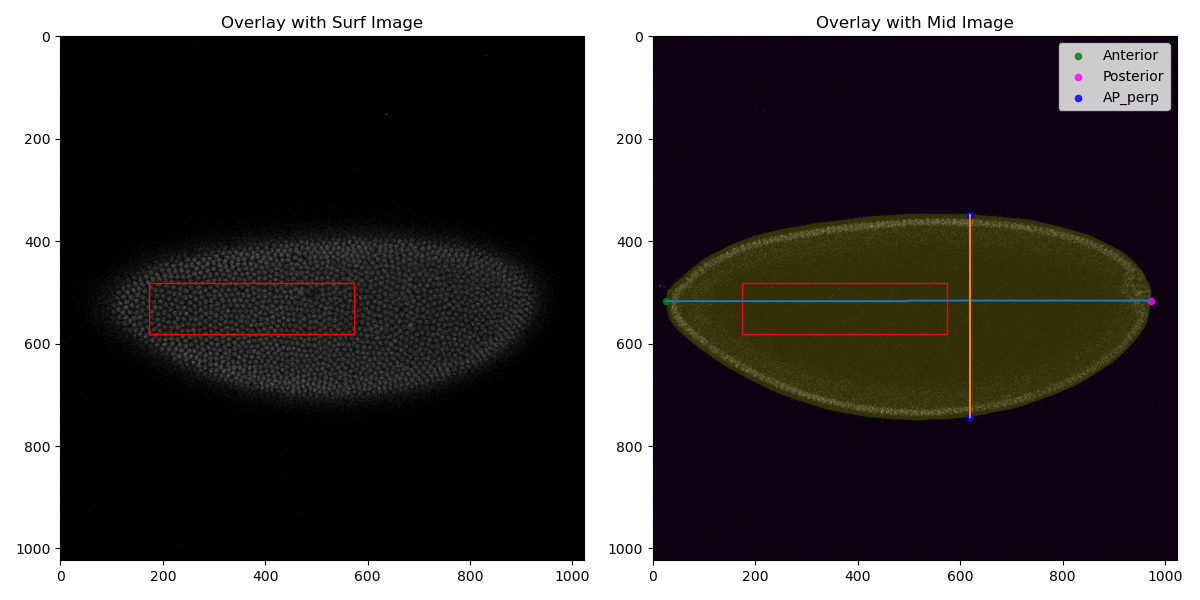

In [18]:
fullEmbryo.find_ap_axis(make_plots=True)

In [19]:
compiled_dataframe = fullEmbryo.xy_to_ap(compiled_dataframe)
compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,ap,ap90
0,1,"[506, 507, 511, 512, 513, 514, 515, 517, 518, ...","[2300.7059993743896, 2304.7430000305176, 2322....","[72.1570804597701, 53.93129347826087, 95.00423...","[25.268212723555116, 24.193128325434877, 23.27...","[425.48808831836254, 423.8314928296911, 425.13...","[221.00383393743027, 221.58308686421765, 221.5...","[0.3313042994154892, 0.33061939863823764, 0.33...","[0.12989276429317786, 0.13046486912365637, 0.1..."
1,2,"[460, 461, 462, 463, 464, 465, 466, 467, 468, ...","[2091.4230003356934, 2095.882999420166, 2100.1...","[57.47963945578232, 38.66103448275862, 90.2138...","[27.24615631798166, 25.318037332850935, 24.569...","[122.58614821001362, 123.76488548423376, 126.0...","[17.180038487563998, 17.208933264743397, 18.12...","[0.20607289824970965, 0.20656023392145914, 0.2...","[-0.07141580498769587, -0.07138726677781301, -..."
2,3,"[527, 528, 529, 530, 531, 532, 533, 534, 535, ...","[2394.573999404907, 2399.2339992523193, 2403.4...","[67.31827607361961, 10.19521568627451, 67.1475...","[26.219966228377146, 26.957198706766793, 25.65...","[588.016012440591, 586.074051884851, 588.18053...","[48.20524698088067, 48.37057827336589, 48.2503...","[0.39849964210332955, 0.3976967603478775, 0.39...","[-0.04077345373697253, -0.0406101626655149, -0..."
3,4,"[572, 573, 574, 576, 577, 578, 580, 581, 582, ...","[2601.6180000305176, 2605.8780002593994, 2610....","[131.19976923076925, 114.73455625, 112.1208231...","[23.632369088123415, 26.48124363284603, 24.361...","[247.29672998614768, 245.9633552657412, 245.16...","[119.09766185700249, 119.2585299587735, 118.06...","[0.25763308598055856, 0.25708181719549955, 0.2...","[0.029244134641654648, 0.029403017599059004, 0..."
4,5,"[486, 489, 490, 491, 492, 493, 494, 495, 496, ...","[2211.6900005340576, 2225.287000656128, 2229.7...","[49.39227659574468, 71.93047777777778, 75.6659...","[23.603968369418688, 23.202337971412053, 23.80...","[473.56080767748307, 471.83975365873124, 471.4...","[127.7748944142374, 128.7753637411546, 128.167...","[0.35117942468222907, 0.3504678742505178, 0.35...","[0.037814288423547136, 0.038802411760013165, 0..."


## RateExtraction Analysis

### Fit and Average

In [20]:
from transcription_pipeline.RateExtraction import FitAndAverage

In [21]:
faadata = FitAndAverage(compiled_dataframe, nc14_start_frame, 40, num_bins, test_dataset_name)

Load previous particle trace fit checking results from "particle_fits_checked.pkl"


/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:556: UserWarning: No particle has been left unchecked
  warn('No particle has been left unchecked')


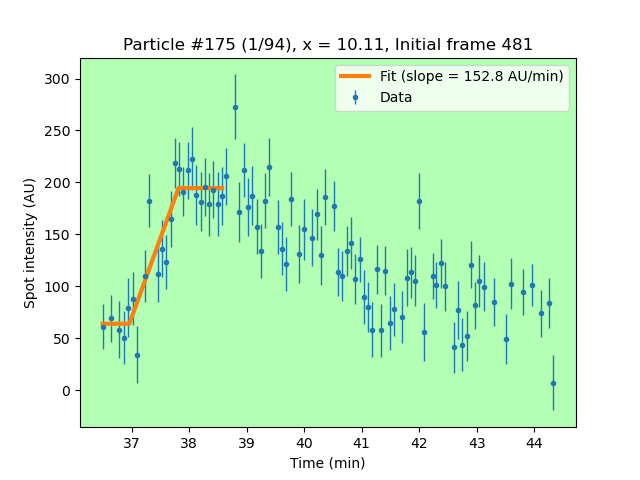

In [22]:
faadata.check_particle_fits()

In [23]:
faadata.save_checked_particle_fits()

No changes made to the particle fit checking results


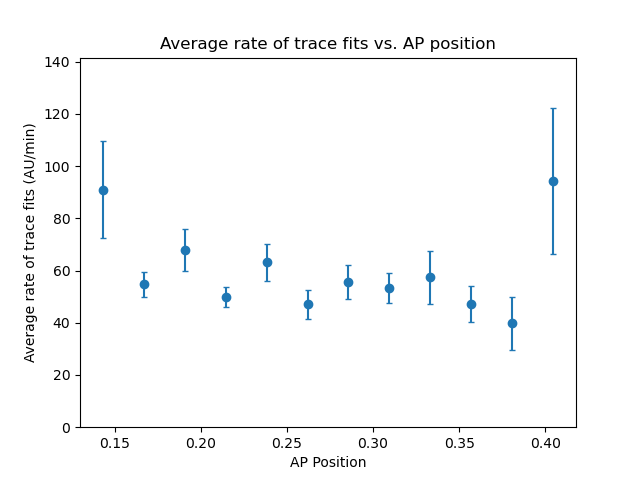

In [24]:
faax, faay, faay_err, _, _ = faadata.average_particle_fits();

### Average and Fit

In [25]:
from transcription_pipeline.RateExtraction import AverageAndFit

In [26]:
time_bin_width = dataset.export_frame_metadata[0]['t_s'][1, 0]
aafdata = AverageAndFit(compiled_dataframe, nc14_start_frame, time_bin_width, num_bins, test_dataset_name)

Load previous bin fit checking results from "bin_fits_checked.pkl"


Moved to bin 7 out of 42, the first unchecked bin


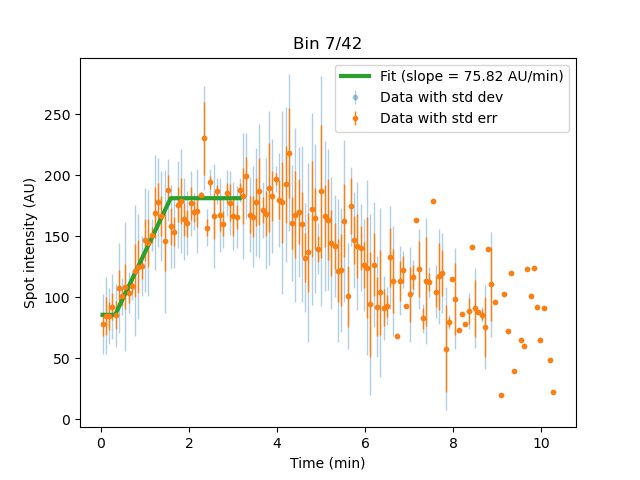

In [27]:
aafdata.check_bin_fits()

In [33]:
aafdata.bin_average_fit_dataframe

,index,time_bin_centers,time_bin_means,time_bin_stddevs,time_bin_stderrs,denoised_time_bin_means,bin_fit_result,bin_fit_slope,bin_fit_result_modified,bin_fit_slope_modified,bin_particle_number,approval_status
0,0,None,None,None,None,None,None,NaN,None,NaN,0,-1
1,1,None,None,None,None,None,None,NaN,None,NaN,0,-1
2,2,None,None,None,None,None,None,NaN,None,NaN,0,-1
3,3,None,None,None,None,None,None,NaN,None,NaN,0,-1
4,4,None,None,None,None,None,None,NaN,None,NaN,0,-1
5,5,None,None,None,None,None,None,NaN,None,NaN,0,-1
6,6,"[0.037116654713948566, 0.1113499641418457, 0.1...","[77.77398044905473, 84.65395397534031, 84.3782...","[24.49793505218771, 31.666523374538322, 22.810...","[10.00124010495038, 15.833261687269161, 11.405...","[114.8619050568798, 115.10015230773826, 115.58...","[[0.037116654713948566, 0.1113499641418457, 0....",75.821791,None,NaN,6,1
7,7,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.96782156556377, 63.95788971831487, 69.5448...","[27.712734332382936, 32.07727107243704, 40.969...","[6.531954123883075, 9.671661131435895, 13.6565...","[87.8323838114404, 88.07514234200306, 88.56935...","[[0.037116654713948566, 0.1113499641418457, 0....",47.432604,None,NaN,16,1
8,8,"[0.037116654713948566, 0.1113499641418457, 0.1...","[65.37488487243616, 70.37409666753474, 75.7296...","[25.743319644090516, 28.96989067808039, 18.009...","[5.61765290040421, 10.242403074351795, 6.00302...","[92.2519298819578, 92.41141194101532, 92.73584...","[[0.037116654713948566, 0.1113499641418457, 0....",49.580075,None,NaN,18,1
9,9,"[0.037116654713948566, 0.1113499641418457, 0.1...","[53.78366013348968, 84.11950096304001, 61.4647...","[21.210677937227143, 18.818167860510084, 18.21...","[4.522131730604968, 7.11259889839687, 6.440398...","[87.38859721476487, 87.60747455794981, 88.0444...","[[0.037116654713948566, 0.1113499641418457, 0....",42.876116,None,NaN,19,1


In [35]:
aafdata.save_checked_bin_fits()

No changes made to the bin fit checking results


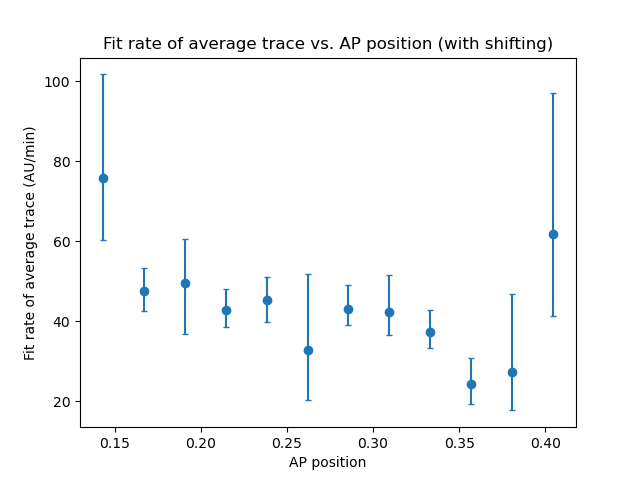

In [36]:
aafx, aafy, aafy_err = aafdata.plot_bin_fits()

### Average and Fit (only on traces used in "Fit and Average") (Move this section before "Average and Fit")

To run this cell, you need to first save the data from "Fit and Average" (i.e. first run `faadata.save_checked_particle_fits()`)

In [37]:
import pandas as pd

faadatapoints = pd.read_pickle(faadata.checked_particle_fits_file_path)

In [40]:
time_bin_width = dataset.export_frame_metadata[0]['t_s'][1, 0]
aafdata_sp = AverageAndFit(faadatapoints, nc14_start_frame, time_bin_width, num_bins, test_dataset_name)

No previous bin fit checking results detected. Do bin fitting for the dataframe.


/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1024: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['bin_particle_number'][bin] = bin_particle_num[bin]
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1044: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.bin_average_fit_dataframe['approval_status'][bin] = -1
/mnt/Data1/Josh/transcription_pipeline/transcription_pipeline/RateExtraction.py:1024: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

Moved to bin 7 out of 42, the first unchecked bin


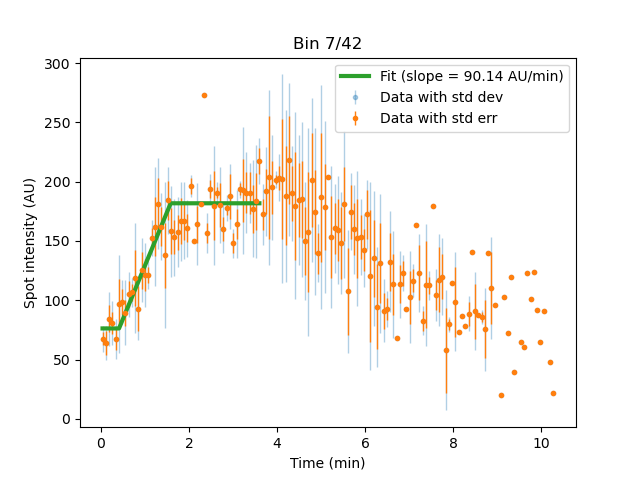

In [41]:
aafdata_sp.check_bin_fits()

In [42]:
aafdata_sp.bin_average_fit_dataframe

,time_bin_centers,time_bin_means,time_bin_stddevs,time_bin_stderrs,denoised_time_bin_means,bin_fit_result,bin_fit_slope,bin_fit_result_modified,bin_fit_slope_modified,bin_particle_number,approval_status
0,None,None,None,None,None,None,NaN,None,NaN,0,-1
1,None,None,None,None,None,None,NaN,None,NaN,0,-1
2,None,None,None,None,None,None,NaN,None,NaN,0,-1
3,None,None,None,None,None,None,NaN,None,NaN,0,-1
4,None,None,None,None,None,None,NaN,None,NaN,0,-1
5,None,None,None,None,None,None,NaN,None,NaN,0,-1
6,"[0.037116654713948566, 0.1113499641418457, 0.1...","[67.48632930423787, 63.68178106508876, 84.3782...","[11.01674170171886, 14.370781065088753, 22.810...","[5.50837085085943, 10.161676742071492, 11.4054...","[103.86939661240524, 104.14236918807137, 104.7...","[[0.037116654713948566, 0.1113499641418457, 0....",90.142362,None,NaN,4,1
7,"[0.037116654713948566, 0.1113499641418457, 0.1...","[68.78780903254895, 53.25478704589906, 71.8133...","[29.857425422913483, 21.976893155331624, 25.55...","[8.280959870435128, 7.325631051777208, 10.4321...","[80.74305577523305, 81.09056875518101, 81.7994...","[[0.037116654713948566, 0.1113499641418457, 0....",56.872044,None,NaN,12,1
8,"[0.037116654713948566, 0.1113499641418457, 0.1...","[64.61780913379408, 71.58294157922894, 67.5625...","[19.620381658699593, 25.333120609830193, 13.06...","[6.540127219566531, 11.329315953156247, 5.8425...","[98.13455686810497, 98.36246169220665, 98.8279...","[[0.037116654713948566, 0.1113499641418457, 0....",62.413125,None,NaN,8,1
9,"[0.037116654713948566, 0.1113499641418457, 0.1...","[57.34281044602585, 101.1327912912913, 66.8797...","[22.141988223671518, 9.44420746356562, 17.1321...","[5.717036776146702, 5.4526157213722835, 7.6617...","[92.71417390484713, 92.93781628738881, 93.3792...","[[0.037116654713948566, 0.1113499641418457, 0....",40.767001,None,NaN,12,1


In [43]:
# aafdata_sp.save_checked_bin_fits()

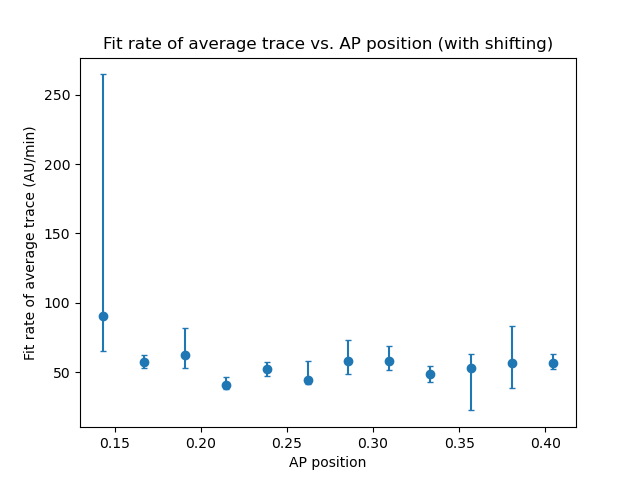

In [45]:
aafspx, aafspy, aafspy_err = aafdata_sp.plot_bin_fits()

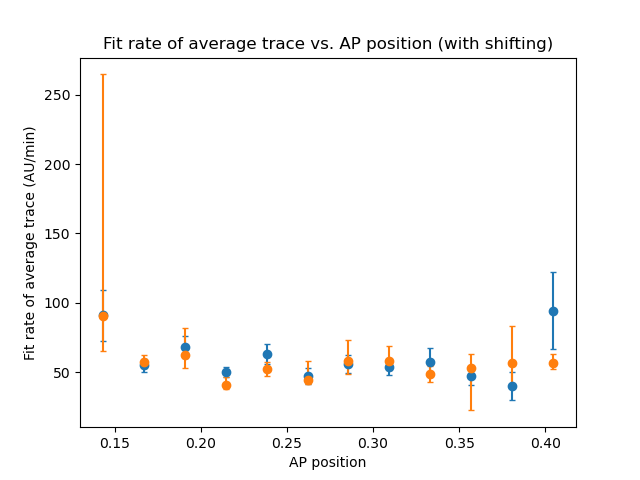

(0.0, 120.0)

In [47]:
plt.figure()
plt.errorbar(faax, faay, yerr=faay_err, capsize=2, fmt='o', label='faa')
#plt.errorbar(aafx, aafy, yerr=aafy_err, capsize=2, fmt='o', label='aaf')
plt.errorbar(aafspx, aafspy, yerr=aafspy_err, capsize=2, fmt='o', label='aafsp')
plt.xlabel('AP position')
plt.ylabel('Fit rate of average trace (AU/min)')
plt.title('Fit rate of average trace vs. AP position (with shifting)')
plt.show()
plt.legend()
plt.ylim(0,120)